In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [2]:
data = pd.read_csv("./data/Titanic_train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 결측값 처리

In [3]:
data['Age'] = data['Age'].fillna(data['Age'].mean())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data = data.drop('Cabin', axis=1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


# Family 컬럼 추가

In [4]:
data['Family'] = data['SibSp'] + data['Parch']

# is_alone_ov7컬럼추가
* 가족없이 혼자 탑승했거나 가족수가 7이 넘으면 사망률이 높음

In [5]:
data['is_alone_ov7'] = data['Family'].apply(lambda x: 1 if x == 0 or x > 6 else 0)

# EDA결과 필요 없는 컬럼 삭제

In [6]:
data = data.drop(['Name', 'Ticket', 'PassengerId', 'Fare', 'SibSp', 'Parch'], axis=1)
data 

,Survived,Pclass,Sex,Age,Embarked,Family,is_alone_ov7
0,0,3,male,22.000000,S,1,0
1,1,1,female,38.000000,C,1,0
2,1,3,female,26.000000,S,0,1
3,1,1,female,35.000000,S,1,0
4,0,3,male,35.000000,S,0,1
...,...,...,...,...,...,...,...
886,0,2,male,27.000000,S,0,1
887,1,1,female,19.000000,S,0,1
888,0,3,female,29.699118,S,3,0
889,1,1,male,26.000000,C,0,1


# Age 컬럼 구간화

In [7]:
data['Age'] = pd.cut(data['Age'], bins=[0, 9, 19, 29, 39, 49, 59, 69, 79, 89]  ,labels=['under10', '10s', '20s','30s','40s','50s','60s','70s','80s'])
data

,Survived,Pclass,Sex,Age,Embarked,Family,is_alone_ov7
0,0,3,male,20s,S,1,0
1,1,1,female,30s,C,1,0
2,1,3,female,20s,S,0,1
3,1,1,female,30s,S,1,0
4,0,3,male,30s,S,0,1
...,...,...,...,...,...,...,...
886,0,2,male,20s,S,0,1
887,1,1,female,10s,S,0,1
888,0,3,female,30s,S,3,0
889,1,1,male,20s,C,0,1


# 종속변수와 독립변수 분리

In [8]:
X = data.drop('Survived', axis=1)
y = data['Survived']

# 데이터셋을 바꿔가면서 최고 성능이 나오는 값 탐색

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix
import warnings
warnings.filterwarnings("ignore", message="Found unknown categories")

In [10]:
result = []
for rs_num in range(1, 200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs_num, stratify=y)
    cate_cols = ['Pclass', 'Sex', 'Age', 'Embarked']
    num_cols = ['Family']
    ohe = OneHotEncoder(drop='first', handle_unknown="ignore", sparse_output=False)
    # one-hot-encoding 훈련 - 카테고리 자료 전체를 조사해서 목록 만들기, 반드시 train 데이터만 fit을 시킴
    ohe.fit(X_train[cate_cols]) 
    X_train_ohe = ohe.transform(X_train[cate_cols]) # fit에서 만든 목록에 숫자 붙여 내보내기
    X_test_ohe = ohe.transform(X_test[cate_cols])
    ohe_cols = ohe.get_feature_names_out(cate_cols)
    # 데이터프레임으로 변환
    X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_cols, index=X_train.index)
    X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_cols, index=X_test.index)
    # 카테고리 변수와 수치 변수 합치기
    X_train_ohe_df = pd.concat([X_train_ohe_df, X_train[num_cols]], axis=1)
    X_test_ohe_df = pd.concat([X_test_ohe_df, X_test[num_cols]], axis=1)
    
    
    for md in range(1,30):
        dtc = DecisionTreeClassifier(max_depth=md, random_state=42, class_weight='balanced')
        dtc.fit(X_train_ohe_df, y_train)
        pred = dtc.predict(X_test_ohe_df)
#         print(accuracy_score(y_test, pred))
        result.append(dict(데이터셋=rs_num, max_depth=md, accuracy=accuracy_score(y_test, pred)))
result_df = pd.DataFrame(result)
result_df.sort_values(by='accuracy', ascending=False, inplace=True)
result_df

,데이터셋,max_depth,accuracy
3860,134,4,0.888060
4410,153,3,0.876866
3946,137,3,0.873134
4412,153,5,0.873134
1858,65,3,0.869403
...,...,...,...
2051,71,22,0.720149
5133,178,1,0.720149
2040,71,11,0.716418
2045,71,16,0.716418


# 가장 성능이 잘 나온 값으로 재분석 및 세부 지표 출력

0.8880597014925373
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       165
           1       0.89      0.81      0.85       103

    accuracy                           0.89       268
   macro avg       0.89      0.87      0.88       268
weighted avg       0.89      0.89      0.89       268

Confusion Matrix:
 [[155  10]
 [ 20  83]]


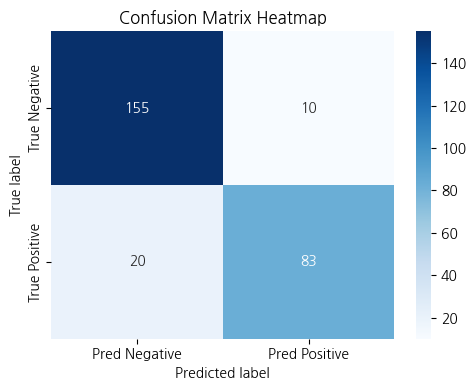

ROC AUC: 0.8908


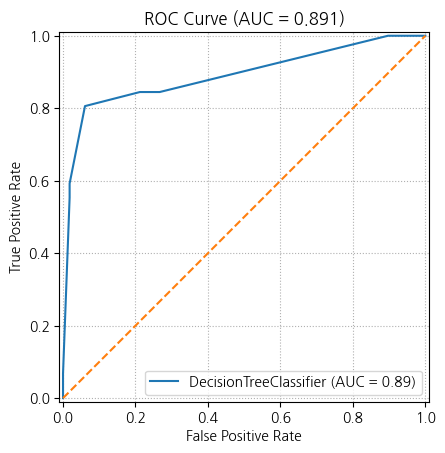

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=result_df.iloc[0,0], stratify=y)
cate_cols = ['Pclass', 'Sex', 'Age', 'Embarked']
num_cols = ['Family']
ohe = OneHotEncoder(drop='first', handle_unknown="ignore", sparse_output=False)
# one-hot-encoding 훈련 - 카테고리 자료 전체를 조사해서 목록 만들기, 반드시 train 데이터만 fit을 시킴
ohe.fit(X_train[cate_cols]) 
X_train_ohe = ohe.transform(X_train[cate_cols]) # fit에서 만든 목록에 숫자 붙여 내보내기
X_test_ohe = ohe.transform(X_test[cate_cols])
ohe_cols = ohe.get_feature_names_out(cate_cols)
# 데이터프레임으로 변환
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_cols, index=X_train.index)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_cols, index=X_test.index)
# 카테고리 변수와 수치 변수 합치기
X_train_ohe_df = pd.concat([X_train_ohe_df, X_train[num_cols]], axis=1)
X_test_ohe_df = pd.concat([X_test_ohe_df, X_test[num_cols]], axis=1)

dtc = DecisionTreeClassifier(max_depth=result_df.iloc[0,1], criterion='gini', random_state=42, class_weight='balanced')
dtc.fit(X_train_ohe_df, y_train)
pred = dtc.predict(X_test_ohe_df)
print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

# confusion_matrix 계산 및 출력
cm = confusion_matrix(y_test, pred)
print("Confusion Matrix:\n", cm)

# 클래스 이름 지정 (원하는 라벨로 변경 가능)
class_names = ['Negative', 'Positive']

# DataFrame 형태로 변환
cm_df = pd.DataFrame(cm,
                     index=[f"True {c}" for c in class_names],
                     columns=[f"Pred {c}" for c in class_names])

# 히트맵 시각화
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Heatmap")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()



# 1) ROC-AUC 수치 출력
y_score = dtc.predict_proba(X_test_ohe_df)[:, 1]   # 양성(1) 클래스 확률
roc_auc = roc_auc_score(y_test, y_score)
print(f"ROC AUC: {roc_auc:.4f}")

# 2) ROC 곡선 그리기 (scikit-learn 권장 방식)
RocCurveDisplay.from_estimator(dtc, X_test_ohe_df, y_test)
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # 기준선
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, linestyle=":")
plt.show()

# 🎯 Titanic 데이터 분석 결과 해석 리포트 (최종 버전)

아래 내용은 DecisionTreeClassifier로 수행한 **Titanic 생존자 예측 모델**의 성능을  
실제 출력된 confusion matrix를 기준으로 정리한 분석 보고서이다.

---

# ✅ 1. 핵심 성능 요약

- **정확도(Accuracy)**: **0.89**  
  → 전체 268명 중 **89%**를 정확히 맞춤

- **ROC-AUC**: **0.8908 (약 0.891)**  
  → 모델이 ‘생존 vs 사망’을 전반적으로 **잘 구분**함  
    (0.5 = 랜덤, 1.0 = 완벽)

---

# ✅ 2. 클래스별 Precision · Recall · F1-score 분석

| 클래스 | 의미 | Precision | Recall | F1-score | Support |
|-------|------|----------|--------|----------|---------|
| **0** | 사망 | **0.89** | **0.94** | **0.91** | 165명 |
| **1** | 생존 | **0.89** | **0.81** | **0.85** | 103명 |

### 🔹 클래스 0(사망) 해석
- Precision 0.89 → 사망이라고 예측한 사람 중 89%가 실제 사망  
- Recall 0.94 → 실제 사망자 100명 중 94명을 맞춤  
✅ 사망자 판별 성능이 매우 우수함

### 🔹 클래스 1(생존) 해석
- Precision 0.89 → 생존 예측 자체의 정확도는 좋음  
- Recall 0.81 → 실제 생존자 19%는 놓침  
⚠ 생존자를 사망으로 예측하는 FN이 비교적 있음

---

# ✅ 3. 전체 평균 지표 해석

| 지표 | 값 | 설명 |
|------|-----|------|
| **Accuracy** | 0.89 | 전체 정확도 |
| **Macro Avg** | Precision 0.89 / Recall 0.87 / F1 0.88 | 단순 평균 |
| **Weighted Avg** | Precision 0.89 / Recall 0.89 / F1 0.89 | 클래스 비율 고려 |

📌 **Macro Recall(0.87)**이 Accuracy보다 낮은 이유  
→ 생존자 Recall이 상대적으로 낮기 때문(0.81)

---

# ✅ 4. ROC Curve 해석

- 파란 ROC 곡선이 **좌측 상단(Top-left)** 에 가까움  
- 랜덤 분류(주황 점선)보다 훨씬 우위  
- **AUC = 0.891** → 임계값을 바꿔도 안정적으로 높은 분류 능력

✅ 모델의 전반적 분리 성능이 매우 우수함

---

# ✅ 5. 혼동행렬(Confusion Matrix) — 실제 출력 기준

실제로 출력된 confusion_matrix:

```python
confusion_matrix(y_test, pred)

array([[155, 10],
       [ 20, 83]])
```
사이킷런 형식은 다음과 같음:
```
[[TN  FP]
 [FN  TP]]
```

## ✅ Confusion Matrix 해석 (scikit-learn 기준)

이를 표로 나타내면:

| 실제 ↓ / 예측 → | 0(사망) | 1(생존) |
|-----------------|---------:|---------:|
| **0(사망)**     | **TN = 155** | **FP = 10** |
| **1(생존)**     | **FN = 20**  | **TP = 83** |

### 🔍 해석 요약
- **TN = 155**: 실제 사망자를 정확히 사망으로 예측  
- **FP = 10**: 실제 사망자 → 생존으로 잘못 예측  
- **FN = 20**: 실제 생존자 → 사망으로 잘못 예측  
- **TP = 83**: 실제 생존자를 정확히 생존으로 예측  

⚠ 생존자(FN=20)를 놓치는 비율이 더 높음 → Recall(0.81) ↓  
✅ 사망자 예측은 매우 우수(Recall 0.94)

---

## ✅ 6. 분류 지표 공식 정리 (scikit-learn 정의 기반)

### ✅ Precision (정밀도)

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

생존자(클래스 1) 기준:

$$
0.89 = \frac{83}{83 + 10}
$$

---

### ✅ Recall (재현율)

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

생존자 기준:

$$
0.81 = \frac{83}{83 + 20}
$$

---

### ✅ Accuracy

$$
\text{Accuracy} = \frac{TP + TN}{\text{Total}}
$$

$$
\text{Accuracy} = \frac{83 + 155}{268} \approx 0.89
$$

---

### ✅ F1-score

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

$$
F1 \approx 2 \cdot \frac{0.89 \cdot 0.81}{0.89 + 0.81} \approx 0.85
$$

---

## ✅ 7. 어떤 상황에서 어떤 지표가 중요한가?

### ✅ Recall(재현율)이 중요한 경우
**FN(놓침)이 치명적일 때**

- 암/중증 질환 진단  
- 사기·이상거래 탐지  
- 보안 침입 탐지  
- 재난 경보 시스템  
➡ *실제 양성을 절대 놓치면 안 되는 상황*

---

### ✅ Precision(정밀도)이 중요한 경우
**FP(잘못된 양성)가 비용이 클 때**

- 고가 프로모션·마케팅 대상 선정  
- 상담/지원 리소스 배분  
- 이메일 스팸 필터  
- 금융 승인·대출 모델  
➡ *양성 예측이 정말 정확해야 하는 상황*

---

### ✅ ROC-AUC이 중요한 경우
**임계값에 구애받지 않는 전반적 성능 평가**

- 여러 모델 비교  
- 임계값(Threshold) 설정 전 단계  
- 클래스 불균형 상황에서도 robust  
➡ *전체적인 분류 능력을 보고 싶을 때 가장 적합*

---

## ✅ 8. Titanic 결과의 실무적 시사점

- 모델은 **정확도(0.89), AUC(0.89)** 모두 우수  
- **사망자 예측은 매우 강함 (Recall = 0.94)**  
- 그러나 **생존자 Recall = 0.81** → 개선 여지 있음

### ✅ 개선 방법 제안
- Threshold 조정하여 생존자 FN 줄이기  
- `class_weight='balanced'` 적용  
- SMOTE 등 오버샘플링 진행  
- 트리 깊이 제한 + 가지치기로 과적합 억제  

---

# 분석에 사용된 주요 변수 추출

In [13]:
importance_df = pd.DataFrame([dtc.feature_importances_], columns=dtc.feature_names_in_).T
importance_df.columns = ['feature_importances']
importance_df

,feature_importances
Pclass_2,0.000000
Pclass_3,0.137035
Sex_male,0.562999
Age_20s,0.000000
Age_30s,0.000000
Age_40s,0.040997
Age_50s,0.001440
Age_60s,0.000000
Age_70s,0.000000
Age_80s,0.012229


<Axes: >

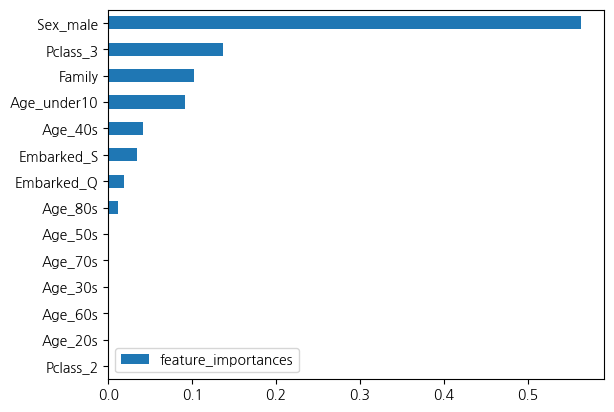

In [14]:
importance_df.sort_values(by="feature_importances").plot(kind="barh")